In [23]:
import numpy as np
import itertools
import astropy.cosmology as cosmology
import scipy.optimize as spo
import scipy.stats as sps
from scipy.stats import norm
import scipy.linalg as la
import scipy as sp
import emcee
#import corner
from datetime import datetime
import hickle
import bisect
import daft
import cProfile
from io import StringIO
import pstats
import sys
import pylab as pl
from sklearn.metrics import confusion_matrix
epsilon = sys.float_info.min
log_epsilon = sys.float_info.min_exp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
colors = 'rbgcymk'
import h5py
#h5py.run_tests()

In [24]:
def safe_log(arr, threshold=epsilon):
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

all keys in truth: 
dict_keys(['data', 'id', 'phi', 'theta'])
n_zs truth:  400
all keys in data: 
dict_keys(['host interim ln prior', 'id', 'interim ln posteriors', 'interim ln prior', 'ln host selection function', 'ln prior info', 'ln selection function', 'ln sn selection function', 'mu_bins', 'sn interim ln prior', 'types', 'z_bins'])
n_types:  3
n_zs:  100
(400, 3, 100, 100) shape post
num_sne:  400
n_mus:  100
CID_1 0.220618959496 40.278962792591386 CID_1 0.2154 40.0807087631
CID_7 0.596743004496 42.825983358113646 CID_7 0.237 40.248812663
CID_0 0.469104779355 42.192471888754525 CID_0 0.2118 40.0526914464


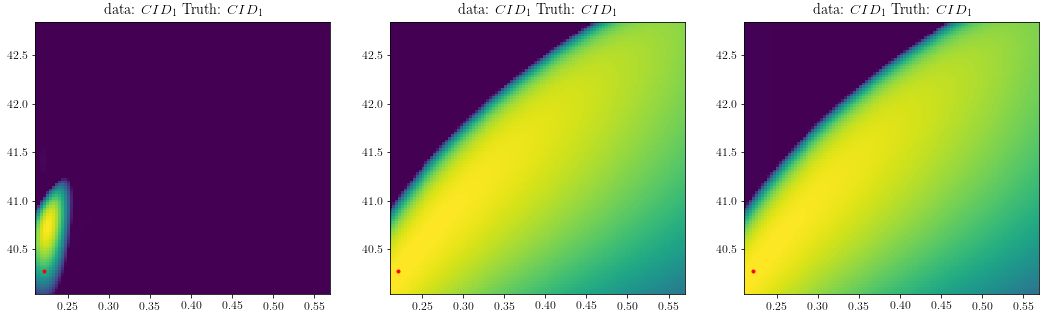

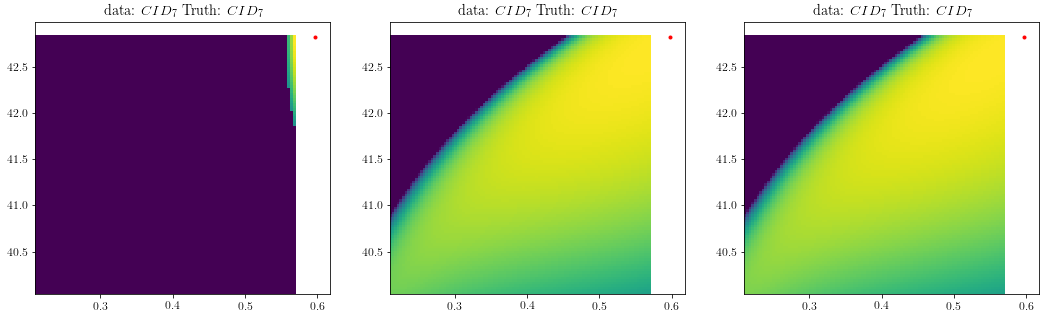

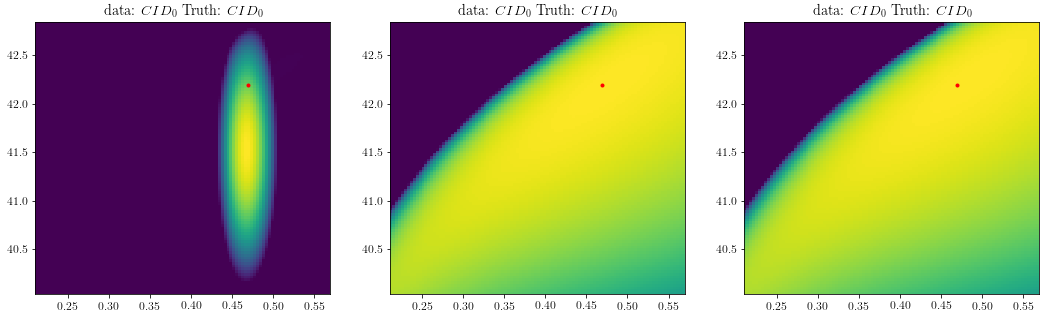

In [25]:
hickle.load_dataset
with open('data/data.hkl', 'r+') as in_file:
    sim_info = hickle.load(in_file)

with open('data/truth.hkl', 'r+') as in_file:
    truth_info = hickle.load(in_file)
    
    
print('all keys in truth: ')
print(truth_info.keys())
    
true_data = truth_info['data']
#print(true_data)

true_zs = [true_param['z'] for true_param in true_data]

print('n_zs truth: ', len(true_zs))
true_mus = [true_param['mu'] for true_param in true_data]

true_types = [true_param['t'] for true_param in true_data]
true_id = truth_info['id']

#true_types = true_data['t']
#true_z = true_data['z']
#true_mu=true_data['mu']

print('all keys in data: ')
print(sim_info.keys())

types = sim_info['types']
n_types = len(types)
print('n_types: ', n_types)

z_bins = sim_info['z_bins']
z_difs = z_bins[1:] - z_bins[:-1]
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.
n_zs = len(z_difs)
sn_id = sim_info['id']


print('n_zs: ', n_zs)

mu_bins = sim_info['mu_bins']

ln_int_post = sim_info.get('interim ln posteriors')
num_sne = np.shape(ln_int_post)[0]

print(np.shape(ln_int_post), 'shape post')
print('num_sne: ', num_sne)


#pl.figure(100)
#for s in range(num_sne):
    #print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_mids[s], mu_mids[s])
#    pl.plot(true_zs[s], z_bins[s] , marker='.', linestyle='None')
    
    
#pl.xlabel('true z')
#pl.ylabel('data z')
mu_difs = mu_bins[1:] - mu_bins[:-1]
#print(z_bins)
#print(z_difs)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.
n_mus = len(mu_difs)
print('n_mus: ', n_mus)



fig = plt.figure(figsize=(n_types*6, 5))
p = 0
for s in [1,7,0]:
#range(5):
    fig = plt.figure(figsize=(n_types*6, 5))
    print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_mids[s], mu_mids[s])
    p = 0
    for t in range(3):
        p += 1
        
        #print(sn_id[s], true_id[s])
        plt.subplot(1, n_types, p)
        plt.pcolormesh(z_bins, mu_bins, ln_int_post[s,t,:,:].T, cmap='viridis')
        plt.scatter(true_zs[s], true_mus[s], marker='.', color='r', linestyle='None')
        plt.title(r'data: $%s$ Truth: $%s$'%(sn_id[s], true_id[s]))

In [4]:
#print(true_types)

## Integrating over both mu and z to get P(type)

In [26]:
type_tmp=np.zeros((num_sne,3))

# Making sure to convert to posterior (not log post) and then do simple integral. This should be improved later
# scipy.integrate.simps(y, x=None, dx=1, axis=-1, even='avg')

#for zi in range(1,n_zs):
#    for mui in range(1,n_mus):
        
type_tmp[:,:] =np.dot(np.dot(np.exp(ln_int_post[:,:,:,:]),mu_difs), z_difs)
        
        #*(z_bins[zi]-z_bins[zi-1])*(mu_bins[mui]-mu_bins[mui-1])


# Ensure that the probabilities are normalised
norm = np.sum(type_tmp, axis=1)
type_tmp[:,0]=type_tmp[:,0]/norm
type_tmp[:,1]=type_tmp[:,1]/norm
type_tmp[:,2]=type_tmp[:,2]/norm


## Now we assign the classified type by the highest probability.

Confusion matrix, without normalization
[[157   0   0]
 [  3  34   4]
 [ 19  33 150]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.07  0.83  0.1 ]
 [ 0.09  0.16  0.74]]


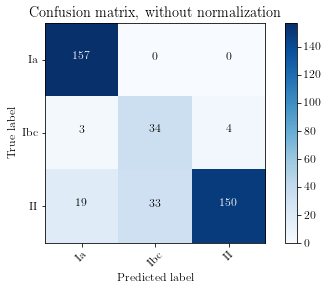

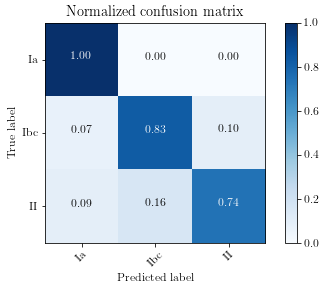

In [27]:
type_converter = {'Ia': 0, 'Ibc': 1, 'II': 2}
true_types_indices = [type_converter[m] for m in true_types]
true_type = np.argmax(type_tmp, axis=1)
obs_type = true_type

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# conf_mat = skl.metrics.confusion_matrix(true_types_indices, true_type)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_types_indices, obs_type)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=types,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=types, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
# true_types_indices = [type_converter[m] for m in true_types]
# true_type = np.argmax(type_tmp, axis=1)# Planck 2015 results XIV. Dark energy and modified gravity - Figure 3

# plt.plot(true_types_indices, true_type)
# conf_mat = skl.metrics.confusion_matrix(true_types_indices, true_type)
true_H0 = 67.9
true_Ode0 = 0.693
true_Om0 = 1. - true_Ode0
true_w0 = -1.09
true_wa = -0.20
true_hyperparams = np.array([true_w0, true_wa])
n_hyperparams = len(true_hyperparams)
#true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)
true_cosmo = cosmology.w0waCDM(true_H0, true_Om0, true_Ode0, w0=true_w0, wa=true_wa)

#for n in range(num_sne):
#    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value

In [8]:
a = np.array([[10, 7, 4], [3, 2, 1]])
print(a)
print(np.percentile(a, 50, axis=0))
print(np.percentile(a, 50, axis=1))

[[10  7  4]
 [ 3  2  1]]
[ 6.5  4.5  2.5]
[ 7.  2.]


In [9]:
#print(true_types_indices)
#print(obs_type)
#print(true_types_indices - obs_type)

Let's make a Hubble plot assuming every SN is Ia, and contrast with the mu assuming true types:

In [29]:
mumed = mumedia=np.zeros(num_sne)
mulow = mulowia=np.zeros(num_sne)
zhigh = zhighia=np.zeros(num_sne)
zlow = zlowia=np.zeros(num_sne)
muhigh = muhighia=np.zeros(num_sne)
zmed = zmedia=np.zeros(num_sne)
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

muerr = zerr=np.zeros(num_sne)
muerria = zerria=np.zeros(num_sne)
import matplotlib.colors as colors
import matplotlib.cm as cmx
vir=cm=plt.cm.BuPu
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=vir)
sm = plt.cm.ScalarMappable(cmap=vir, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
pmin, pmax = log_epsilon, np.log(1./(min(z_difs) * min(mu_difs)))

xy = np.empty((2, num_sne))
xy_ia = np.empty((2, num_sne))
pia = np.zeros(num_sne)

for sn in range(num_sne):
    # Obs type
    hm = ln_int_post[sn,obs_type[sn],:,:].T
    mu_prob =np.dot(np.exp(hm),z_difs)
    muspline = interp1d(mu_prob, mu_bins[:-1])
    indsmu = np.argsort(mu_prob)
    # most probable mu
    mumed[sn]= mu_bins[np.argmax(mu_prob)]
    #print(np.min(mu_prob[indsmu]), np.max(mu_prob[indsmu]))
    mulow[sn] = muspline(np.percentile(mu_prob[indsmu],0.95,interpolation='linear'))
    muhigh[sn] = muspline(np.percentile(mu_prob[indsmu],0.05,interpolation='linear'))
    
    zm = ln_int_post[sn,obs_type[sn],:,:]
    z_prob = np.dot(np.exp(zm) ,mu_difs[:])
    zspline = interp1d(z_prob, z_bins[:-1])
    indsz = np.argsort(z_prob)
    # most probable z
    zmed[sn]= z_bins[np.argmax(z_prob)]
    zlow[sn] = zspline(np.percentile(z_prob[indsz],0.95,interpolation='linear'))
    zhigh[sn] = zspline(np.percentile(z_prob[indsz],0.05,interpolation='linear'))
    
    # Ia type
    hmia = ln_int_post[sn,0,:,:].T
    mu_probia = np.dot(np.exp(hmia),z_difs)
    #print(np.min(mu_probia), np.min(mu_bins[:-1]), np.max(mu_probia), np.max(mu_bins[:-1]))
    musplineia = interp1d(mu_probia, mu_bins[:-1])
    indsmuia = np.argsort(mu_probia)
    
    # most probable mu
    mumedia[sn]= mu_bins[np.argmax(mu_probia)]
    mulowia[sn] = musplineia(np.percentile(mu_probia[indsmuia],0.95,interpolation='linear'))
    muhighia[sn] = musplineia(np.percentile(mu_probia[indsmuia],0.05,interpolation='linear'))

    zmia = ln_int_post[sn,0,:,:]
    z_probia = np.dot(np.exp(zmia), mu_difs[:])
    zspline = interp1d(z_probia, z_bins[:-1])
    indszia = np.argsort(z_probia)
    # most probable z
    zmedia[sn]= z_bins[np.argmax(z_probia)]
    zlowia[sn] = zspline(np.percentile(z_probia[indszia],0.95,interpolation='linear'))
    zhighia[sn] = zspline(np.percentile(z_probia[indszia],0.05,interpolation='linear'))

    #print(sn, (obs_type[sn], np.argmax(mu_prob), np.argmax(z_prob)), (0, np.argmax(mu_probia), np.argmax(z_probia)))
    xy[0][sn] = z_bins[np.argmax(z_prob)]
    xy[1][sn] = mu_bins[np.argmax(mu_prob)]
    xy_ia[0][sn] = z_bins[np.argmax(z_probia)]
    xy_ia[1][sn] = mu_bins[np.argmax(mu_probia)]
    pia[sn] = type_tmp[sn, 0]
    muerr[sn]=np.max([mumed[sn]-mulow[sn], muhigh[sn]-mumed[sn]])
    
    zerr[sn]=np.max([zmed[sn]-zlow[sn], zhigh[sn]-zmed[sn]])
    muerria[sn]=np.max([mumedia[sn]-mulowia[sn], muhighia[sn]-mumedia[sn]])
    zerria[sn]=np.max([zmedia[sn]-zlowia[sn], zhighia[sn]-zmedia[sn]])

pl.figure(10,figsize=(8,6))
#plt.errorbar(zmed[indsmu], mumed[indsmu], yerr=muerr, xerr=zerr, marker='o', linestyle='None', color='teal')
print(np.shape(xy))
plt.errorbar(xy_ia[0], xy_ia[1], yerr=muerr, xerr=zerr, marker='o', color='teal', linestyle='None')

for ic, ind in enumerate(indsmu):
    plt.scatter(true_zs[ind], true_mus[ind], marker='.', color='r', linestyle='None')
#plt.errorbar(zmedia[indsmuia], mumedia[indsmuia],yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='orange')

pl.title('assuming every SN is its most probable type')
pl.xlabel('z',fontsize=16)
pl.ylabel(r'$\mu(z)$', fontsize=16)
pl.ylim(40., 45.)
plt.xlim(0.15, 0.65)
pl.savefig('fakeHubble_maxprob.png')
plt.show()
pl.close()

mu_cosmo=true_cosmo.distmod(xy_ia[0,ic]).value

pl.figure(10,figsize=(10,8))
ax = plt.subplot(111)
# plt.errorbar(zmedia[indsmuia], mumedia[indsmuia],yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='teal')
#plt.errorbar(xy_ia[0], xy_ia[1], yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='teal')
ziavec = np.zeros(len(true_zs))
muiavec = np.zeros(len(true_zs))
colorVal = [] #np.zeros(len(indsmuia))]

#                  true_zs[indsmuia]
#muavec = true_mus[indsmuia]
#sortz=np.argsort(ziavec)
#print(ziavec)

for i in range(len(true_zs)):
    
    ziavec[i] = true_zs[i]
    muiavec[i] = true_mus[i]
    
#for ic, ind in enumerate(indsmuia):
    #print(pia[ic],xy_ia[0,ic], xy_ia[1,ic] )
       

    #ziavec[ic] = true_zs[ind]
 #   muiavec[ic] = true_mus[ind]
 
print(np.min(ziavec), np.max(ziavec))
print(np.min(xy_ia[0,:]), np.max(xy_ia[0,:]))


sortz=np.argsort(ziavec)
true_muspl = interp1d(ziavec[sortz], muiavec[sortz])
splined_mu = true_muspl(xy_ia[0,:])



for ic in range(len(xy_ia[0,:])):
    colorVal.append(scalarMap.to_rgba(pia[ic]))
    im=ax.errorbar(xy_ia[0,ic], (xy_ia[1,ic]), 
                   yerr=muerr[ic],  marker='o', color=colorVal[ic])

    #-splined_mu[ic])/splined_mu[ic]
#plt.errorbar(zmedia[indsmuia], mumedia[indsmuia],yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='orange')
#plt.plot(ziavec[sortz], muiavec[sortz] , color='b') #, linestyle='None')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(sm)
#pl.title('assuming every SN is Ia')
pl.xlabel(r'Redshift $z$',fontsize=20)
pl.ylabel(r'$(\mu(z)-\mu_{true}(z))/\mu_{true}(z)$', fontsize=20)
pl.xscale('log')
#pl.ylim(40., 45.)
#plt.xlim(0.15, 0.65)
pl.savefig('fakeHubble_assumeIa.png')
plt.show()
pl.close()

ValueError: A value in x_new is below the interpolation range.